# UW-Madison GI Tract Image Segmentation

## Inference

In [124]:
#!/usr/bin/env python

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()
import numpy as np
import os
import re
import cv2
from plotly.offline import init_notebook_mode
from glob import glob

import tensorflow as tf

# Visualization Imports
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm; tqdm.pandas();
import plotly.express as px
import seaborn as sns
from PIL import Image, ImageEnhance
import matplotlib; print(f"\t\t– MATPLOTLIB VERSION: {matplotlib.__version__}");
from matplotlib import animation, rc; rc('animation', html='jshtml')
from matplotlib.colors import LinearSegmentedColormap
import plotly
import PIL
import cv2

		– MATPLOTLIB VERSION: 3.5.2


In [2]:
%cd 'hpc_train_files'

/Users/viktor/Documents/BA/GIT/HealthyOrganTracker/hpc_train_files


In [3]:
from config import CFG
from dataloader import DataGenerator
from loss import dice_coef, iou_coef, dice_loss, bce_dice_loss
from datapreparation import extract_metadata, remove_faulties

In [12]:
## Helper 

## Config ⚙️


In [58]:
BASE_PATH = 'input/uw-madison-gi-tract-image-segmentation/'
TRAIN_DIR =  BASE_PATH +'train'
TRAIN_CSV =  BASE_PATH +'train.csv'
STYE = "multilabel"
DEBUG = True

"""
Backbones available: 
        'efficientnetb0'
        'efficientnetb5'
        'efficientnetb7'
        'inceptionresnetv2'
        'inceptionv3'
        'resnet50'
        'resnext50'
        'resnext101'
        'seresnext50'
        'seresnext101'
        'densenet121'
        'densenet201'
        """

"\nBackbones available: \n        'efficientnetb0'\n        'efficientnetb5'\n        'efficientnetb7'\n        'inceptionresnetv2'\n        'inceptionv3'\n        'resnet50'\n        'resnext50'\n        'resnext101'\n        'seresnext50'\n        'seresnext101'\n        'densenet121'\n        'densenet201'\n        "

In [5]:
df = pd.read_csv(TRAIN_CSV)
#df = df.sample(n=90, random_state=1)

In [6]:
cfg = CFG(
    backbone            = 'efficientnetb0',
    img_dims            = (32,32,3),
    model               = 'UNet',
    batch_size          = 16, 
    epochs              = 1, 
    kaggle              = False, 
    use_fold_csv        = True,
    semi3d_data         = True,
    remove_faulty_cases = True,
    use_crop_data       = True)

In [122]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
# modified from: https://www.kaggle.com/inversion/run-length-decoding-quick-start
def rle_decode(mask_rle, shape, color=1):
    """ TBD
    
    Args:
        mask_rle (str): run-length as string formated (start length)
        shape (tuple of ints): (height,width) of array to return 
    
    Returns: 
        Mask (np.array)
            - 1 indicating mask
            - 0 indicating background

    """
    # Split the string by space, then convert it into a integer array
    s = np.array(mask_rle.split(), dtype=int)

    # Every even value is the start, every odd value is the "run" length
    starts = s[0::2] - 1
    lengths = s[1::2]
    ends = starts + lengths

    # The image image is actually flattened since RLE is a 1D "run"
    if len(shape)==3:
        h, w, d = shape
        img = np.zeros((h * w, d), dtype=np.float32)
    else:
        h, w = shape
        img = np.zeros((h * w,), dtype=np.float32)

    # The color here is actually just any integer you want!
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
        
    # Don't forget to change the image back to the original shape
    return img.reshape(shape)

# https://www.kaggle.com/namgalielei/which-reshape-is-used-in-rle
def rle_decode_top_to_bot_first(mask_rle, shape):
    """ TBD
    
    Args:
        mask_rle (str): run-length as string formated (start length)
        shape (tuple of ints): (height,width) of array to return 
    
    Returns:
        Mask (np.array)
            - 1 indicating mask
            - 0 indicating background

    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape((shape[1], shape[0]), order='F').T  # Reshape from top -> bottom first

# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    """ TBD
    
    Args:
        img (np.array): 
            - 1 indicating mask
            - 0 indicating background
    
    Returns: 
        run length as string formated
    """
    
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def flatten_l_o_l(nested_list):
    """ Flatten a list of lists """
    return [item for sublist in nested_list for item in sublist]

def load_json_to_dict(json_path):
    """ tbd """
    with open(json_path) as json_file:
        data = json.load(json_file)
    return data

def tf_load_png(img_path):
    return tf.image.decode_png(tf.io.read_file(img_path), channels=3)

def open_gray16(_path, normalize=True, to_rgb=False):
    """ Helper to open files """
    if normalize:
        if to_rgb:
            return np.tile(np.expand_dims(cv2.imread(_path, cv2.IMREAD_ANYDEPTH)/65535., axis=-1), 3)
        else:
            return cv2.imread(_path, cv2.IMREAD_ANYDEPTH)/65535.
    else:
        if to_rgb:
            return np.tile(np.expand_dims(cv2.imread(_path, cv2.IMREAD_ANYDEPTH), axis=-1), 3)
        else:
            return cv2.imread(_path, cv2.IMREAD_ANYDEPTH)
        
def rle_decode_tf(mask_rle, shape):
    """ TBD """
    
    shape = tf.convert_to_tensor(shape, tf.int64)
    size = tf.math.reduce_prod(shape)
    
    # Split string
    s = tf.strings.split(mask_rle)
    s = tf.strings.to_number(s, tf.int64)
    
    # Get starts and lengths
    starts = s[::2] - 1
    lens = s[1::2]
    
    # Make ones to be scattered
    total_ones = tf.reduce_sum(lens)
    ones = tf.ones([total_ones], tf.uint8)
    
    # Make scattering indices
    r = tf.range(total_ones)
    lens_cum = tf.math.cumsum(lens)
    s = tf.searchsorted(lens_cum, r, 'right')
    idx = r + tf.gather(starts - tf.pad(lens_cum[:-1], [(1, 0)]), s)
    
    # Scatter ones into flattened mask
    mask_flat = tf.scatter_nd(tf.expand_dims(idx, 1), ones, [size])
    
    # Reshape into mask
    return tf.reshape(mask_flat, shape)

# Custom color map in matplotlib
def CustomCmap(rgb_color):

    r1,g1,b1 = rgb_color

    cdict = {'red': ((0, r1, r1),
                   (1, r1, r1)),
           'green': ((0, g1, g1),
                    (1, g1, g1)),
           'blue': ((0, b1, b1),
                   (1, b1, b1))}

    cmap = LinearSegmentedColormap('custom_cmap', cdict)
    return cmap


## Load Dataframe with crop infos

In [7]:
df_train = extract_metadata(df, TRAIN_DIR, channels=3, stride=2)
df_train.sample(5)

Frame merged. Shape: (38496, 21)
Remove faulty cases: True
Sucess. Shape: (38208, 21)


,id,large_bowel,small_bowel,stomach,case,day,slice,path,width,height,...,pixel_y,count,path00,path01,path02,image_paths,rs,re,cs,ce
10135,case43_day20_slice_0072,,,34223 16 34246 9 34487 36 34752 38 35018 39 35...,43,20,72,input/uw-madison-gi-tract-image-segmentation/t...,266,266,...,1.50,1,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,[input/uw-madison-gi-tract-image-segmentation/...,45,10000,0,266
28233,case125_day15_slice_0122,,,,125,15,122,input/uw-madison-gi-tract-image-segmentation/t...,266,266,...,1.50,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,[input/uw-madison-gi-tract-image-segmentation/...,43,10000,0,266
9088,case41_day25_slice_0033,,,,41,25,33,input/uw-madison-gi-tract-image-segmentation/t...,266,266,...,1.50,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,[input/uw-madison-gi-tract-image-segmentation/...,26,10000,0,266
25027,case118_day14_slice_0084,13391 10 13407 7 13655 14 13671 11 13690 3 139...,13711 5 13976 11 14241 15 14507 16 14773 17 15...,,118,14,84,input/uw-madison-gi-tract-image-segmentation/t...,266,266,...,1.50,2,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,[input/uw-madison-gi-tract-image-segmentation/...,4,10000,0,266
1213,case7_day13_slice_0062,,,26772 3 27035 8 27300 10 27565 12 27831 12 280...,7,13,62,input/uw-madison-gi-tract-image-segmentation/t...,266,266,...,1.50,1,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,[input/uw-madison-gi-tract-image-segmentation/...,16,10000,0,266


## Generate Original Masks

In [87]:
IMAGE_SHAPE = SEG_SHAPE = (224,224)

def make_seg_mask(row, output_dir, resize_to, resize=False):
    """"""
    _slice_shape = (row.height, row.width)
    counter  = 0
    
    if not pd.isna(row.large_bowel):
        lb_mask = rle_decode(row.large_bowel, _slice_shape)
    else:
        lb_mask = np.zeros(_slice_shape)
        counter +=1
        
    if not pd.isna(row.small_bowel):
        sb_mask = rle_decode(row.small_bowel, _slice_shape)
    else:
        sb_mask = np.zeros(_slice_shape)
        counter +=1
        
    if not pd.isna(row.stomach):
        st_mask = rle_decode(row.stomach, _slice_shape)
    else:
        st_mask = np.zeros(_slice_shape)
        counter +=1
    
    mask_arr = np.stack([lb_mask, sb_mask, st_mask], axis=-1)
    
    if resize:
        mask_arr = cv2.resize(mask_arr, resize_to, interpolation=cv2.INTER_NEAREST).astype(np.uint8)
            
    mask_path = os.path.join(output_dir, f"{row.id}_mask.png")
    if counter != 3:
        cv2.imwrite(mask_path, mask_arr)
        
    return mask_path

## Plot Masks Helper


In [59]:

def plot_masks_chronologic(imgs, masks, ids, alpha=1):
    
    slices = [i.split("_")[-1] for i in ids]
    
    # Plot
    fig, axs = plt.subplots(2, 5, figsize=(23, 11))
    axs = axs.flatten()
    
    for k, (img, mask) in enumerate(zip(imgs, masks)):

        # Change pixels - when 1 make True, when 0 make NA
        mask = np.ma.masked_where(mask == 0, mask)

        # Split the channels
        mask_largeB = mask[:, :, 0]
        mask_smallB = mask[:, :, 1]
        mask_stomach = mask[:, :, 2]
        
        title = f"{k+1}. Slice {slices[k]}"
        axs[k].set_title(title, fontsize = 16, 
                         color = my_colors[-1], weight='bold')

        axs[k].imshow(img, cmap="gist_gray")
        axs[k].axis("off")
        axs[k].imshow(mask_largeB, interpolation='none', cmap=CMAP1, alpha=alpha)
        axs[k].imshow(mask_smallB, interpolation='none', cmap=CMAP2, alpha=alpha)
        axs[k].imshow(mask_stomach, interpolation='none', cmap=CMAP3, alpha=alpha)
        axs[k].axis("off")
    
    axs[0].legend(legend_colors, labels, loc=2)
    plt.tight_layout()
    plt.show()

In [46]:
outputdir = os.path.join(BASE_PATH, "masks")
outputdir

'input/uw-madison-gi-tract-image-segmentation/masks'

In [88]:
df_train["multilabel_mask_path"] = df_train.progress_apply(lambda _row: make_seg_mask(_row, outputdir, resize_to=SEG_SHAPE, resize=False), axis=1)

  0%|          | 0/38208 [00:00<?, ?it/s]

## VIsualiize

In [127]:
mask_colors = [(1.0, 0.7, 0.1), (1.0, 0.5, 1.0), (1.0, 0.22, 0.099)]
legend_colors = [Rectangle((0,0),1,1, color=color) for color in mask_colors]
labels = ["Large Bowel", "Small Bowel", "Stomach"]

CMAP1 = CustomCmap(mask_colors[0])
CMAP2 = CustomCmap(mask_colors[1])
CMAP3 = CustomCmap(mask_colors[2])

In [133]:
def plot_original_mask(img, mask, alpha=1):

    # Change pixels - when 1 make True, when 0 make NA
    mask = np.ma.masked_where(mask == 0, mask)

    # Split the channels
    mask_largeB = mask[:, :, 0]
    mask_smallB = mask[:, :, 1]
    mask_stomach = mask[:, :, 2]


    # Plot the 2 images (Original and with Mask)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

    # Original
    ax1.set_title("Original Image")
    ax1.imshow(img)
    ax1.axis("off")

    # With Mask
    ax2.set_title("Image with Mask")
    ax2.imshow(img)
    ax2.imshow(mask_largeB, interpolation='none', cmap=CMAP1, alpha=alpha)
    ax2.imshow(mask_smallB, interpolation='none', cmap=CMAP2, alpha=alpha)
    ax2.imshow(mask_stomach, interpolation='none', cmap=CMAP3, alpha=alpha)
    ax2.legend(legend_colors, labels)
    ax2.axis("off")
    
#     fig.savefig('foo.png', dpi=500)
    plt.show()
def get_overlay(img, mask, _alpha=0.999, _beta=0.45, _gamma=0):
    
    # Normalize to be between 0-1 (float32)
    img = (img/img.max()).astype(np.float32)
    

    mask_rgb=mask.astype(np.float32)
    
    # overlay
    seg_overlay = cv2.addWeighted(src1=img, alpha=_alpha, 
                                  src2=mask_rgb, beta=_beta, gamma=_gamma)
    return seg_overlay

def get_miss_overlay(gt_mask, pred_mask, _alpha=0.9, _beta=0.25, _gamma=0):
    
    # Make mask RGB and float32
    miss_rgb = np.zeros((*pred_mask.shape[:2],3), dtype=np.float32)
    
    if len(pred_mask.shape)==2:
        miss_rgb[..., 1] = np.where((gt_mask==pred_mask)&(gt_mask!=0), 0.8, 0.0)
        miss_rgb[..., 0] = np.where((gt_mask!=pred_mask), 0.8, 0.0)
    else:
        
        miss_rgb = np.where((gt_mask==pred_mask)&(gt_mask!=0.0), (0.0,0.8,0.0), (0.0,0.0,0.0))
        miss_rgb = np.where((gt_mask!=pred_mask), (0.8,0.0,0.0), miss_rgb)
        
    return miss_rgb

def plot_preds(img, pred_mask, gt_mask):
    gt_overlay = get_overlay(img, gt_mask)
    pred_overlay = get_overlay(img, pred_mask)
    miss_overlay = get_miss_overlay(gt_mask, pred_mask)
    
    plt.figure(figsize=(20,12))
    
    for i, (_desc, _img) in enumerate(zip(["Original", "Prediction Mask", "Ground-Truth Mask", "Miss Mask"], [img, pred_overlay, gt_overlay, miss_overlay])):        
        plt.subplot(1,4,i+1)
        plt.imshow(_img)
        plt.title(f"{_desc} Image", fontweight="bold")        
        plt.axis(False)
        
        if i in [1,2]:
            handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
            labels = ["Large Bowel Segmentation Map", "Small Bowel Segmentation Map", "Stomach Segmentation Map"]
            plt.legend(handles,labels)
        elif i==3:
            handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.0,0.8,0.0), (0.8,0.0,0.0), (0.0, 0.0, 0.0)]]
            labels = ["Agreement", "Disagreement", "Background"]
            plt.legend(handles,labels)
    plt.tight_layout()
    plt.show()


In [135]:
# Full Example
ID = "case123_day20_slice_0107"

img_path = df_train[df_train['id'] == ID]['path'].values[0]
mask_path = df_train[df_train['id'] == ID]['multilabel_mask_path'].values[0]

# Read image
img = open_gray16(img_path, normalize=True, to_rgb=True)
mask = open_gray16(mask_path, normalize= True, to_rgb=True )
pred = np.zeros(img.shape )
# Get mask


In [136]:
img.shape

(266, 266, 3)

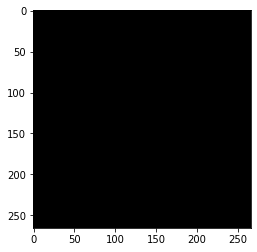

In [137]:
plt.imshow(mask)


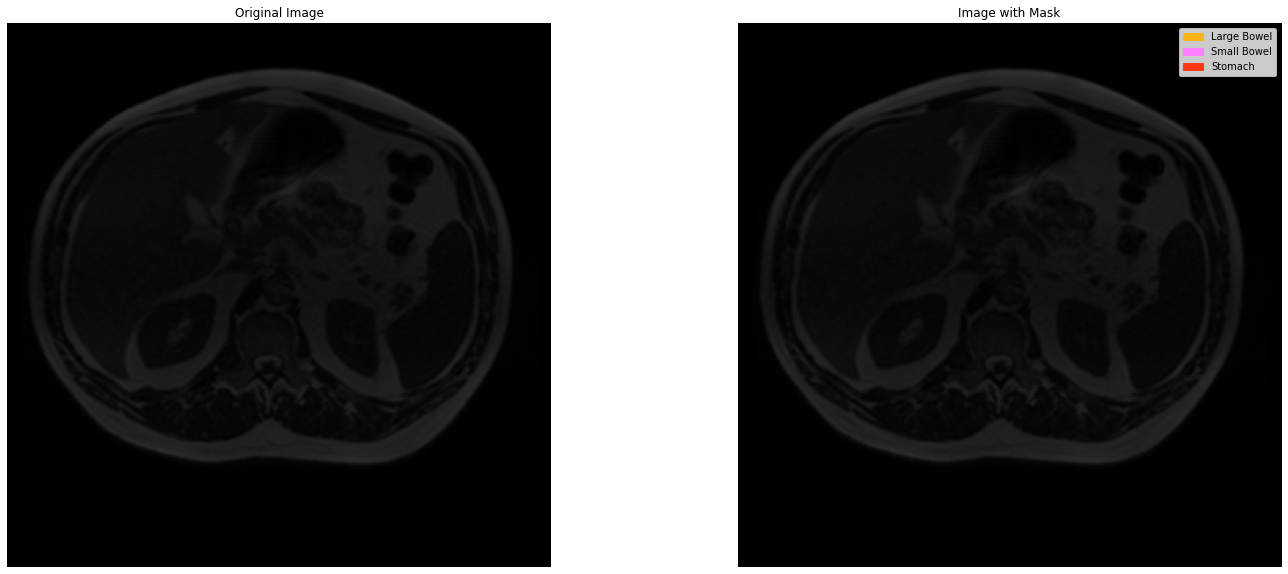

In [134]:
plot_original_mask(img, mask, alpha=1)